In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# extract data from zip file
import zipfile
import os

# Define the path to your zip file and the directory where you want to extract it
zip_file_path = '/content/drive/MyDrive/465 Project/archive.zip'
extract_folder_path = '/content/data'

os.makedirs(extract_folder_path, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder_path)


In [ ]:
# lib imports
import torch
import os
import numpy as np
import pandas as pd
import random
import cv2

from tqdm import tqdm

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

In [ ]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

In [ ]:
# Set the directories containing the images and masks
image_dir = '/content/data/Grains'
mask_dir = '/content/data/Segmented'

# Set the target image size
target_size = (IMG_WIDTH, IMG_HEIGHT)

# Create empty lists to hold the images and masks
images = []
masks = []

# Iterate through the directories and load the images and masks
for file in sorted(os.listdir(image_dir)):
    # Load the image and resize to the target size
    img = cv2.imread(os.path.join(image_dir, file))
    img = cv2.resize(img, target_size)

    # Append the resized image to the list of images
    images.append(img)

for file in sorted(os.listdir(mask_dir)):

    # Load the corresponding mask and resize to the target size
    #mask_file = file.replace('.jpg', '.png')
    mask = cv2.imread(os.path.join(mask_dir, file))
    mask = cv2.resize(mask, target_size)

    # Append the resized mask to the list of masks
    masks.append(mask)

In [ ]:
image_x = random.randint(0, 300)
image_x

12

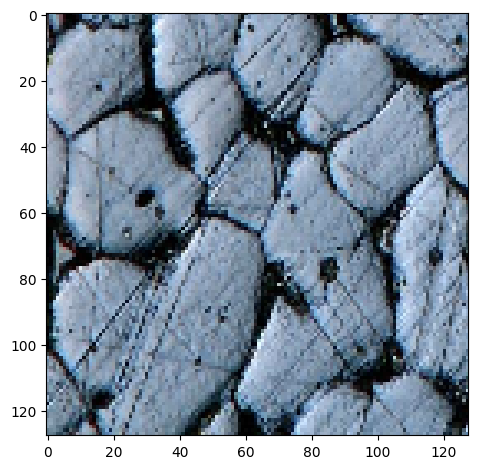

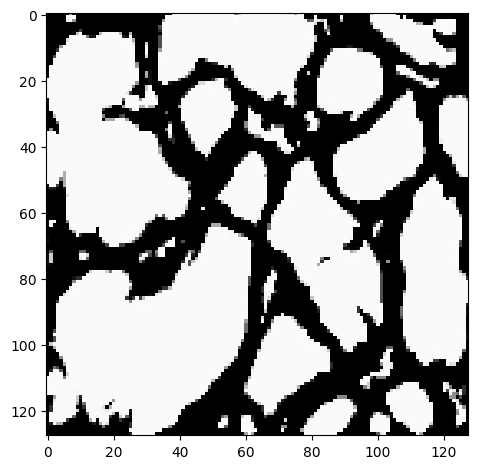

In [ ]:
# example
imshow(images[image_x])
plt.show()
imshow(masks[image_x])
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        # Contraction path
        self.conv1 = self.contracting_block(in_channels, 16)
        self.conv2 = self.contracting_block(16, 32)
        self.conv3 = self.contracting_block(32, 64)
        self.conv4 = self.contracting_block(64, 128)
        self.conv5 = self.contracting_block(128, 256)


        # Expansive path
        self.upconv6 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv6 = self.expansive_block(256, 128)
        self.upconv7 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv7 = self.expansive_block(128, 64)
        self.upconv8 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.conv8 = self.expansive_block(64, 32)
        self.upconv9 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.conv9 = self.expansive_block(32, 16)

        # Output layer
        self.output_conv = nn.Conv2d(16, out_channels, kernel_size=1)

    def contracting_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            # nn.MaxPool2d(kernel_size=2)
        )

    def expansive_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1)
        )

    def forward(self, x):
        # Contraction path
        mx_pool = nn.MaxPool2d(kernel_size=2)
        c1 = self.conv1(x)
        p1 = mx_pool(c1)
        c2 = self.conv2(p1)
        p2 = mx_pool(c2)
        c3 = self.conv3(p2)
        p3 = mx_pool(c3)
        c4 = self.conv4(p3)
        p4 = mx_pool(c4)
        c5 = self.conv5(p4)

        # Expansive path
        u6 = self.upconv6(c5)
        # print(c5.shape)
        # print(u6.shape, c4.shape) # for debugging
        u6 = torch.cat([u6, c4], dim=1)
        c6 = self.conv6(u6)
        u7 = self.upconv7(c6)
        u7 = torch.cat([u7, c3], dim=1)
        c7 = self.conv7(u7)
        u8 = self.upconv8(c7)
        u8 = torch.cat([u8, c2], dim=1)
        c8 = self.conv8(u8)
        u9 = self.upconv9(c8)
        u9 = torch.cat([u9, c1], dim=1)
        c9 = self.conv9(u9)

        # Output layer
        outputs = self.output_conv(c9)
        return torch.sigmoid(outputs)


# Instantiate the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = UNet(IMG_CHANNELS, 1).to(device)

# print(model)

In [ ]:
from torchsummary import summary
summary(model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             448
              ReLU-2         [-1, 16, 128, 128]               0
            Conv2d-3         [-1, 16, 128, 128]           2,320
              ReLU-4         [-1, 16, 128, 128]               0
           Dropout-5         [-1, 16, 128, 128]               0
            Conv2d-6           [-1, 32, 64, 64]           4,640
              ReLU-7           [-1, 32, 64, 64]               0
            Conv2d-8           [-1, 32, 64, 64]           9,248
              ReLU-9           [-1, 32, 64, 64]               0
          Dropout-10           [-1, 32, 64, 64]               0
           Conv2d-11           [-1, 64, 32, 32]          18,496
             ReLU-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          36,928
             ReLU-14           [-1, 64,

In [ ]:
# create the X and Y (input and output)

X_train = np.array(images)
Y_train = np.array(masks)
print(X_train.shape, Y_train.shape)
# change the Y to a boolean
Y_train = np.where(Y_train > 245, True, False)

(336, 128, 128, 3) (336, 128, 128, 3)


In [ ]:
# careful to run this cell only once (otherwise shape changes)
X_train = np.transpose(X_train, (0, 3, 1 , 2))
Y_train = np.transpose(Y_train, (0, 3, 1 , 2))
print(X_train.shape, Y_train.shape)

(336, 3, 128, 128) (336, 3, 128, 128)


In [ ]:
#convert the boolean where it insion s true (any of the 3 channels) to a (336, 128, 128, 1)
#basically reduce the 3 channel dimeRGB to just one boolean value

Y_t= np.any(Y_train, axis=1)
print(Y_t.shape)
Y_t = Y_t.reshape(336, 1, 128, 128)
print(Y_t.shape)


(336, 128, 128)
(336, 1, 128, 128)


In [ ]:
################################

# create the checkpoint path

checkpoint_path = '/content/checkpoint_path/GrainsTraining.ckpt'
os.makedirs("/content/checkpoint_path", exist_ok=True)
checkpoint_dir = os.path.dirname(checkpoint_path)


In [ ]:
# prompt: Make Dataset from data

from torch.utils.data import Dataset

class GrainDataset(Dataset):
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = torch.from_numpy(self.images[idx]).float()
        mask = torch.from_numpy(self.masks[idx]).float()
        return image, mask

# Create the dataset
dataset = GrainDataset(X_train, Y_t)



In [ ]:
# prompt: create train and validation dataset

from torch.utils.data import random_split

# Split the dataset into train and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])



In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
# Define optimizer and loss function
optimizer = optim.Adam(model.parameters())


# Define DataLoader for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Define callbacks
class ModelCheckpoint:
    def __init__(self, checkpoint_path):
        self.checkpoint_path = checkpoint_path
        self.best_loss = float('inf')

    def __call__(self, model, val_loss):
        if val_loss < self.best_loss:
            torch.save(model.state_dict(), self.checkpoint_path)
            print("Checkpoint saved")
            self.best_loss = val_loss

checkpointer = ModelCheckpoint(checkpoint_path)

class BCEDiceLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input, target):
        bce = F.binary_cross_entropy_with_logits(input, target)
        smooth = 1e-5
        input = torch.sigmoid(input)
        num = target.size(0)
        input = input.view(num, -1)
        target = target.view(num, -1)
        intersection = (input * target)
        dice = (2. * intersection.sum(1) + smooth) / (input.sum(1) + target.sum(1) + smooth)
        dice = 1 - dice.sum() / num
        return 0.5 * bce + dice


criterion = BCEDiceLoss().to(device)
# criterion = nn.BCELoss()

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    # Training
    for inputs, targets in train_loader:
        inputs, targets = inputs.cuda(), targets.cuda()
        optimizer.zero_grad()
        # print(inputs.shape)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)

    # Average losses
    train_loss /= len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)

    # Print epoch statistics
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # Call the ModelCheckpoint callback
    checkpointer(model, val_loss)


Epoch [1/20], Train Loss: 0.7040, Val Loss: 0.6686
Checkpoint saved
Epoch [2/20], Train Loss: 0.6471, Val Loss: 0.6499
Checkpoint saved
Epoch [3/20], Train Loss: 0.6395, Val Loss: 0.6456
Checkpoint saved
Epoch [4/20], Train Loss: 0.6348, Val Loss: 0.6426
Checkpoint saved
Epoch [5/20], Train Loss: 0.6332, Val Loss: 0.6412
Checkpoint saved
Epoch [6/20], Train Loss: 0.6309, Val Loss: 0.6425
Epoch [7/20], Train Loss: 0.6285, Val Loss: 0.6381
Checkpoint saved
Epoch [8/20], Train Loss: 0.6260, Val Loss: 0.6427
Epoch [9/20], Train Loss: 0.6248, Val Loss: 0.6344
Checkpoint saved
Epoch [10/20], Train Loss: 0.6229, Val Loss: 0.6366
Epoch [11/20], Train Loss: 0.6215, Val Loss: 0.6328
Checkpoint saved
Epoch [12/20], Train Loss: 0.6204, Val Loss: 0.6319
Checkpoint saved
Epoch [13/20], Train Loss: 0.6205, Val Loss: 0.6329
Epoch [14/20], Train Loss: 0.6213, Val Loss: 0.6328
Epoch [15/20], Train Loss: 0.6185, Val Loss: 0.6300
Checkpoint saved
Epoch [16/20], Train Loss: 0.6177, Val Loss: 0.6311
Epoch [

In [ ]:
model.eval()

UNet(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Dropout(p=0.1, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Dropout(p=0.1, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Dropout(p=0.1, inplace=False)
  )
  (conv4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride

In [ ]:
# Set model to evaluation mode
model.eval()

# Select a random index for demonstration
idx = random.randint(0, len(X_train))
print(f"Input data type: {X_train.dtype}")
# Perform predictions on training and validation data
with torch.no_grad():
    preds_train_tensor = model(torch.tensor(X_train[:int(X_train.shape[0]*0.9)], dtype=torch.float32).cuda())
    preds_val_tensor = model(torch.tensor(X_train[int(X_train.shape[0]*0.9):], dtype=torch.float32).cuda())

# Convert predictions to numpy arrays and apply thresholding
preds_train_np = (preds_train_tensor.cpu().numpy() > 0.5).astype(np.uint8)
preds_val_np = (preds_val_tensor.cpu().numpy() > 0.5).astype(np.uint8)

Input data type: uint8


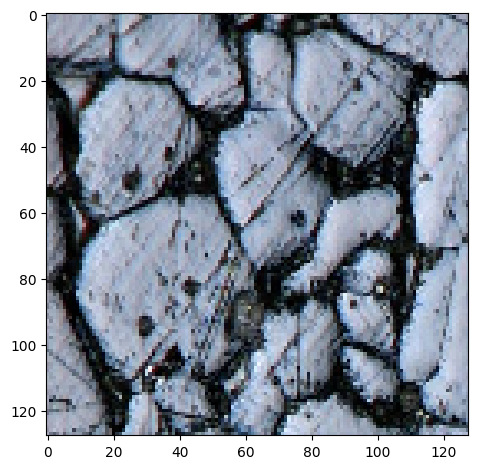

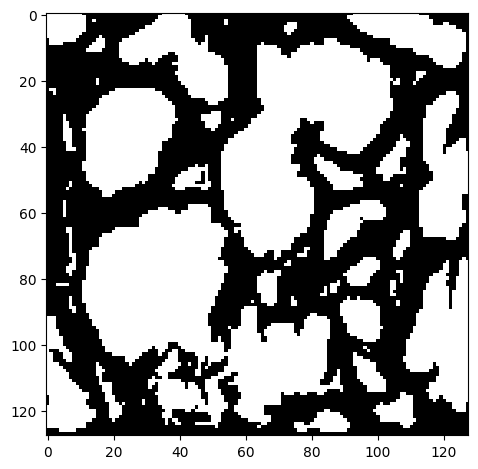

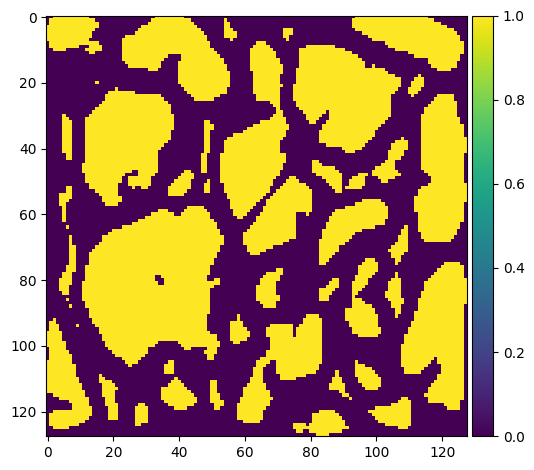

In [ ]:

ix = random.randint(0, len(preds_train_np))
imshow(np.transpose(X_train[ix], (1, 2, 0)))
plt.show()
imshow(np.squeeze(Y_t[ix]))
plt.show()
imshow(np.squeeze(preds_train_np[ix]))
plt.show()